In [ ]:
from collections import defaultdict
from pathlib import Path

import colorcet as cc
import equinox as eqx
import jax
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.analysis.jacobian import jacobian
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    mean_squared_error as mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.metrics.error import relative_error_norm
from dynamics_discovery.models import NeuralODE
from matplotlib_utils.axes_setters import set_labels
from matplotlib_utils.plots import colored_scatterplot


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

EXP_TYPES_ALL = ("vanilla", "jacobian", "tangent_evolution", "neighborhood", "normal")
EXP_TYPES = ("vanilla", "jacobian", "tangent_evolution", "neighborhood")
COLOR_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        ("royalblue", "limegreen", "darkorange", "orangered", "saddlebrown"),
    )
)
LABEL_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        (
            "Vanilla",
            "Jacobian matching",
            "Tangent Evolution matching",
            "Neighborhood-based (ours)",
            "Normal-based (ours)",
        ),
    )
)

In [2]:
def load_experiment(
    exp_type: str,
    key: int,
    downsample: int = 2,
    train_length: int = 2,
    noise: float = 0.0,
    rootdir=Path("../../results/best/lorenz63"),
) -> NeuralODE:
    loaddir = rootdir / f"downsample={downsample}/len={train_length}/{exp_type}"
    model_paths = list(loaddir.glob(f"*_noise={noise}_key={key}*"))

    if len(model_paths) == 0:
        raise ValueError("No models found with the given conditions")
    elif len(model_paths) > 1:
        raise ValueError("Multiple models found with the given conditions!")
    else:
        return load_model(model_paths[0])


In [3]:
downsample = 2
noise = 0.0

datadir = Path("../../data")

dataset_train, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)
dataset_test = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large_test.hdf5")
    .add_noise(noise)
    .apply_transform(transform)
)


In [6]:
key = 0
jacobian_batch = eqx.filter_vmap(jacobian, in_axes=(None, None, 0))
jac_true = jacobian_batch(
    TransformedODE(Lorenz63(), transform), 0.0, dataset_test.u[:, 0]
)


@eqx.filter_jit
def compute_jac_err(model):
    jac_pred = jacobian_batch(model, 0.0, dataset_test.u[:, 0])
    return relative_error_norm(jac_pred, jac_true, axis=(-2, -1))


EXP_TYPES = ("vanilla", "jacobian", "tangent_evolution")
jac_logerr_dict = defaultdict(list)
for exp_type in EXP_TYPES:
    jac_logerr_dict[exp_type] = [
        np.log10(compute_jac_err(load_experiment(exp_type, key, dt, 2, noise)))
        for dt in (2, 10, 40)
    ]

In [7]:
jac_logerr_dict

defaultdict(list,
            {'vanilla': [array([-0.57413856, -0.73438184, -0.56991466, ..., -1.10840282,
                     -0.76877345, -1.10605038], shape=(20000,)),
              array([-0.76516206, -0.55853921, -0.35111759, ..., -1.37009697,
                     -0.79263039, -1.3168904 ], shape=(20000,)),
              array([-0.8680304 , -0.75902794, -0.63487795, ..., -1.03664994,
                     -0.87392164, -0.84977976], shape=(20000,))],
             'jacobian': [array([-2.78158211, -2.87051996, -3.14467546, ..., -2.96747574,
                     -3.1355102 , -3.02022105], shape=(20000,)),
              array([-2.74047737, -2.71997863, -3.06639997, ..., -2.98565854,
                     -2.88948133, -2.92691083], shape=(20000,)),
              array([-2.73460881, -2.54764153, -2.7379669 , ..., -3.05671253,
                     -2.78081029, -2.73129167], shape=(20000,))],
             'tangent_evolution': [array([-2.88665696, -2.70172339, -2.86337939, ..., -3.00917515,


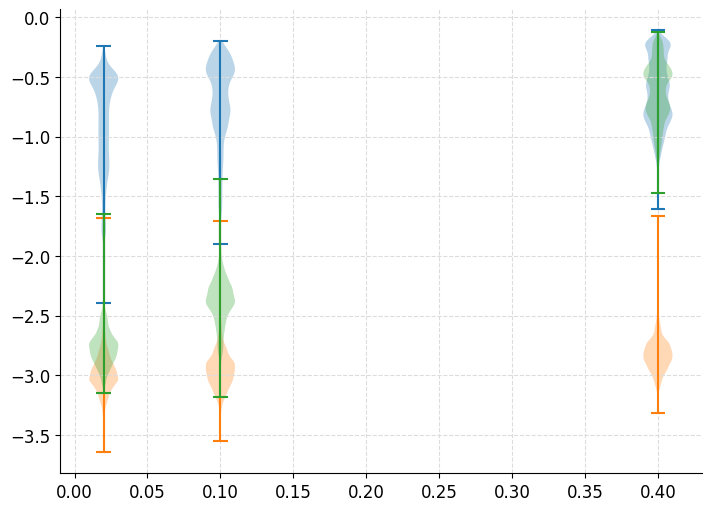

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for exp_type in EXP_TYPES:
    ax.violinplot(
        jac_logerr_dict[exp_type], np.asarray((2, 10, 40)) * 0.01, widths=0.02
    )

Text(0, 0.5, '$\\log_{10}||\\mathbf{J}_{true}-\\mathbf{J}_{pred}||_F\\;/\\;||\\mathbf{J}_{true}||_F$')

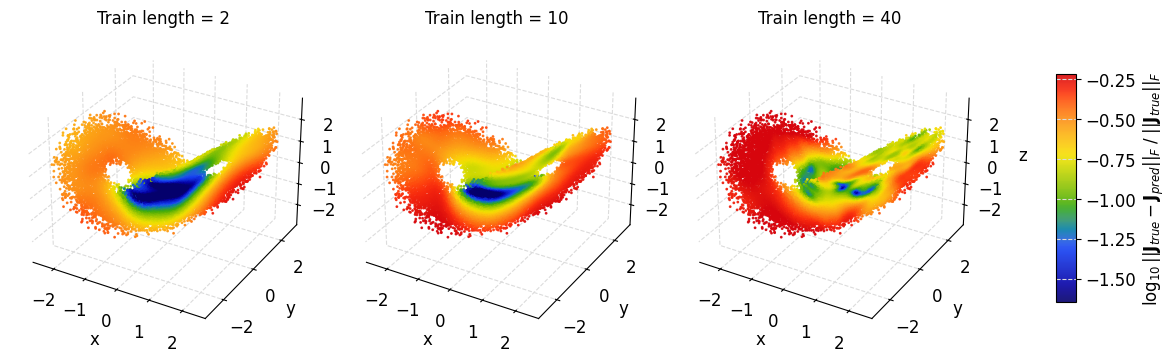

In [5]:
fig = colored_scatterplot(
    [dataset_test.u[:, 0].T] * len(jac_logerr_dict),
    list(jac_logerr_dict.values()),
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)
for i, train_len in enumerate(jac_logerr_dict.keys()):
    fig.axes[i].set_title(f"Train length = {train_len}", fontsize="medium")
    set_labels(fig.axes[i], ["x", "y", "z"])
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
)

In [24]:
downsample = 2
noise = 0.0

datadir = Path("../../data")

dataset_train, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "rossler76_train.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)
dataset_test = (
    TimeSeriesDataset.from_hdf5(datadir / "rossler76_test.hdf5")
    .add_noise(noise)
    .apply_transform(transform)
)


In [25]:
key = 0
jacobian_batch = eqx.filter_vmap(jacobian, in_axes=(None, None, 0))
jac_true = jacobian_batch(
    TransformedODE(Lorenz63(), transform), 0.0, dataset_test.u[:, 0]
)


@eqx.filter_jit
def compute_jac_err(model):
    jac_pred = jacobian_batch(model, 0.0, dataset_test.u[:, 0])
    return relative_error_norm(jac_pred, jac_true, axis=(-2, -1))


EXP_TYPES = ("vanilla", "jacobian", "tangent_evolution")
jac_logerr_dict = defaultdict(list)
for exp_type in EXP_TYPES:
    jac_logerr_dict[exp_type] = [
        np.log10(compute_jac_err(load_experiment(exp_type, key, dt, 2, noise)))
        for dt in (2, 10, 40)
    ]

(-0.25, 0.1)

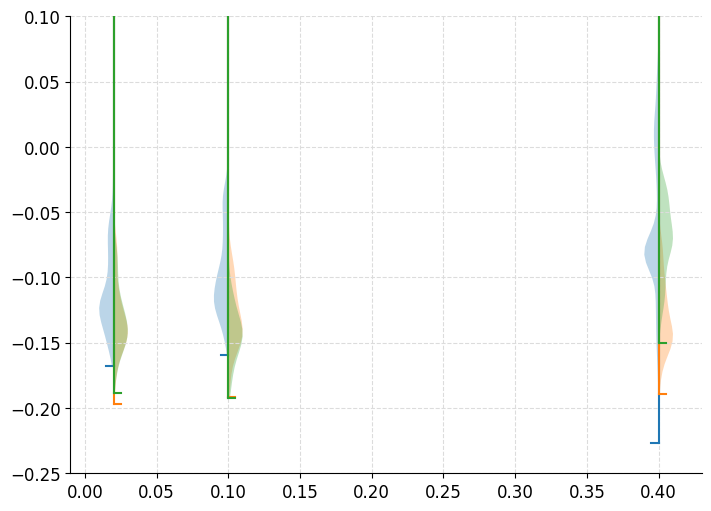

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for exp_type, side in zip(EXP_TYPES, ("low", "high", "high")):
    ax.violinplot(
        jac_logerr_dict[exp_type],
        np.asarray((2, 10, 40)) * 0.01,
        widths=0.02,
        side=side,
    )
ax.set_ylim((-0.25, 0.1))